# NSE CDF Analysis

Quick analysis of Mamba model NSE performance on test set.

In [1]:
from transfer_learning_publication.evaluation import MetricCalculator
import polars as pl
import matplotlib.pyplot as plt

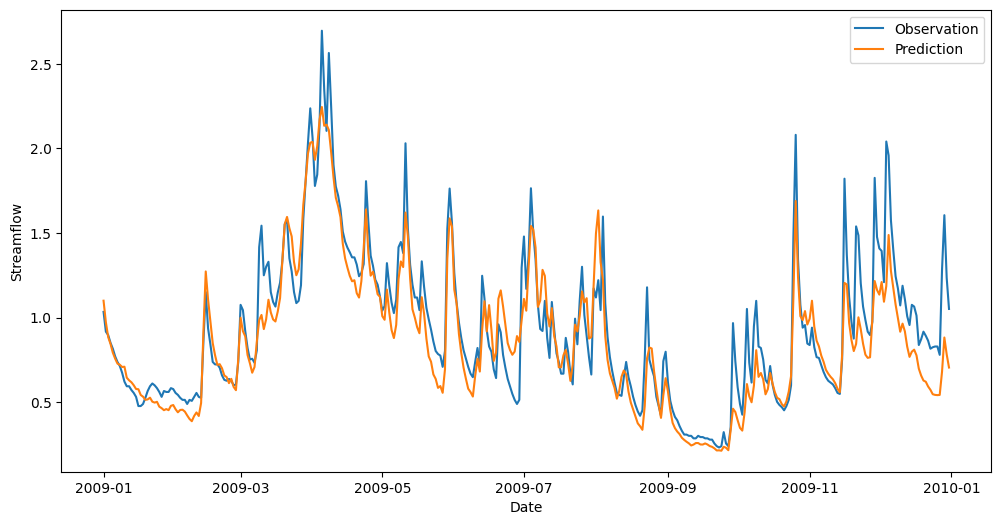

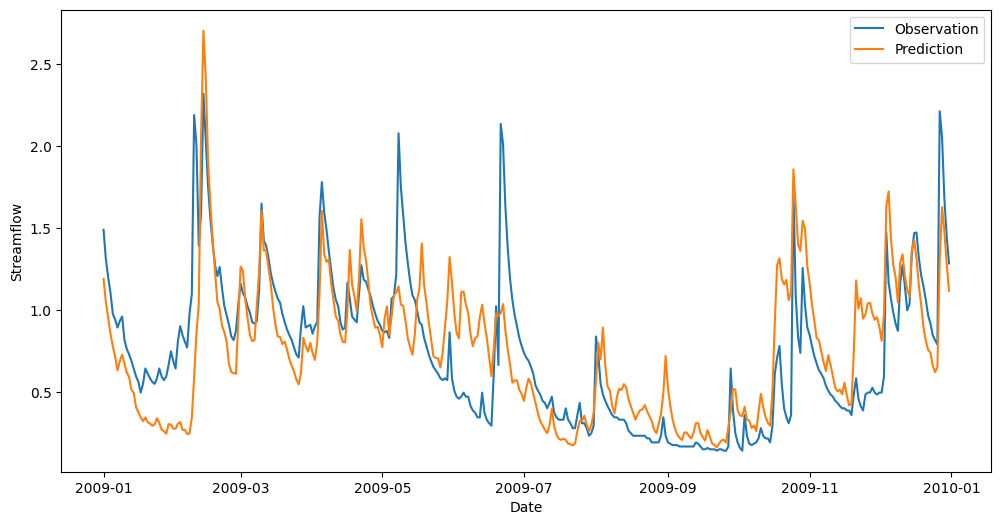

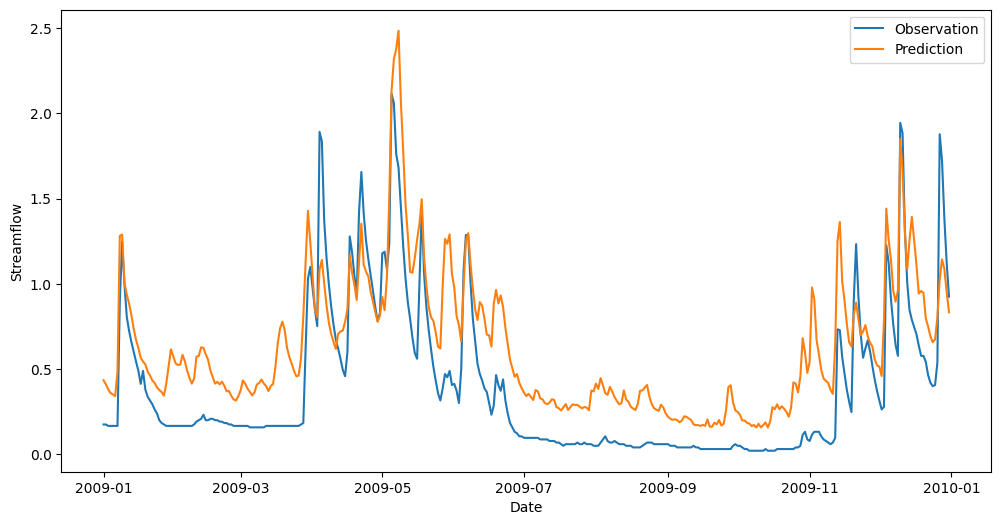

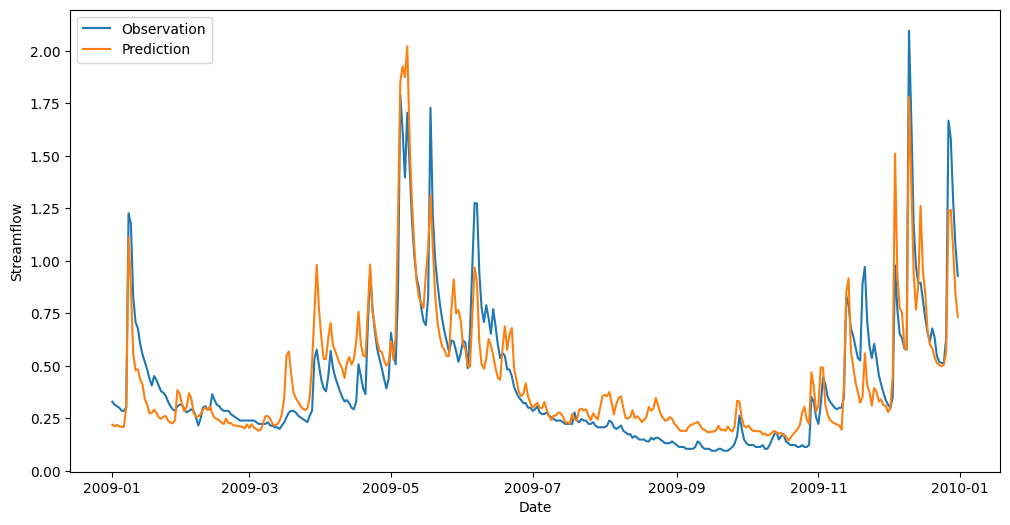

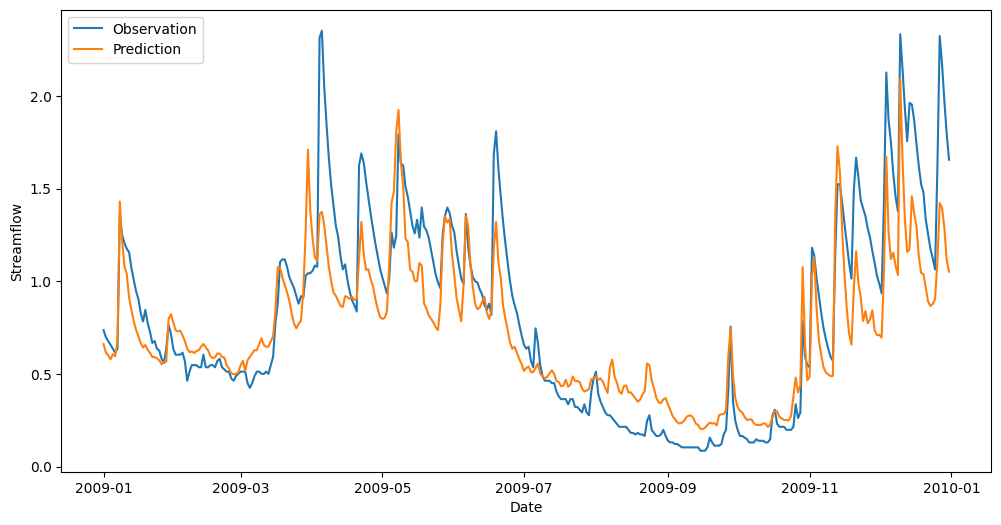

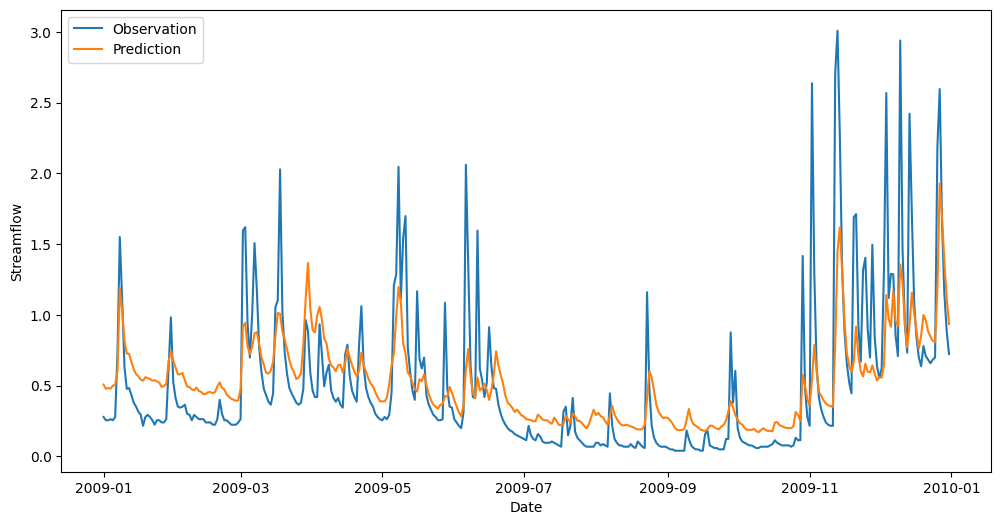

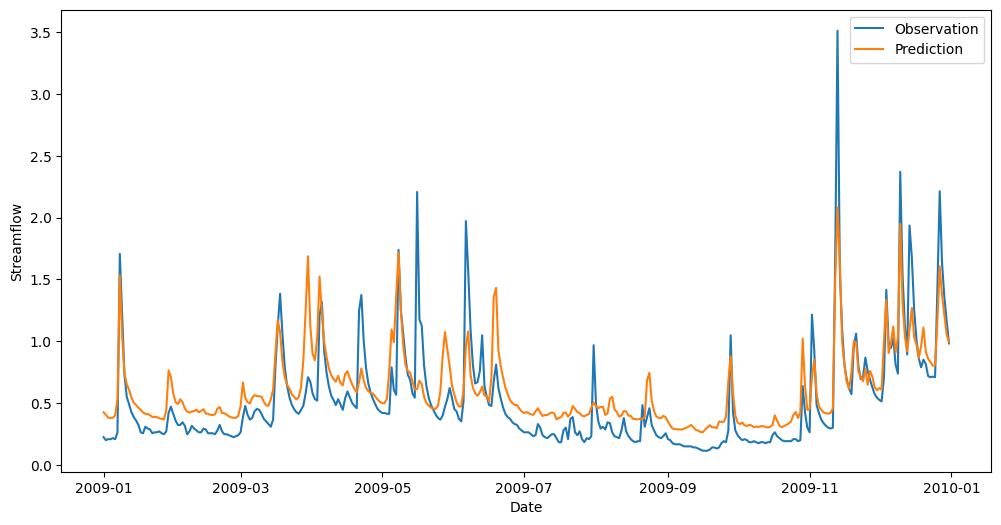

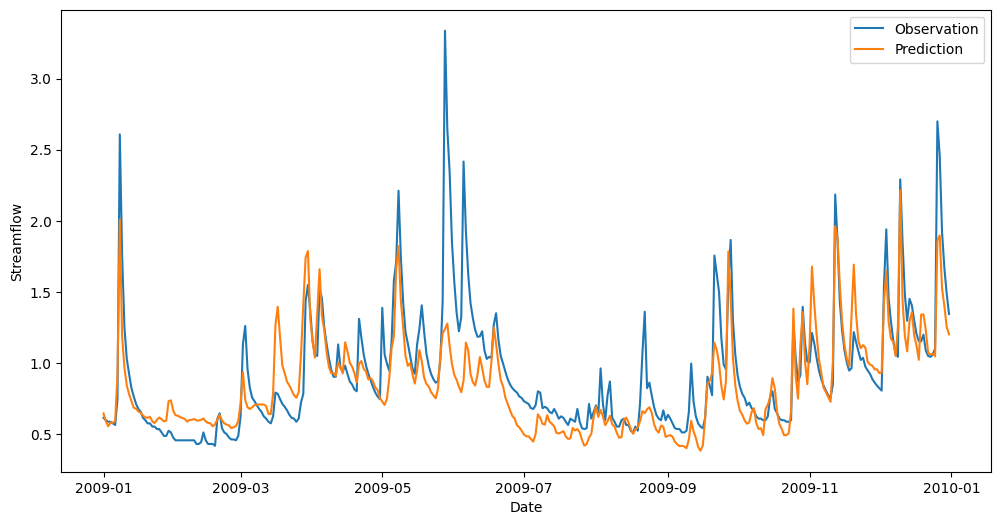

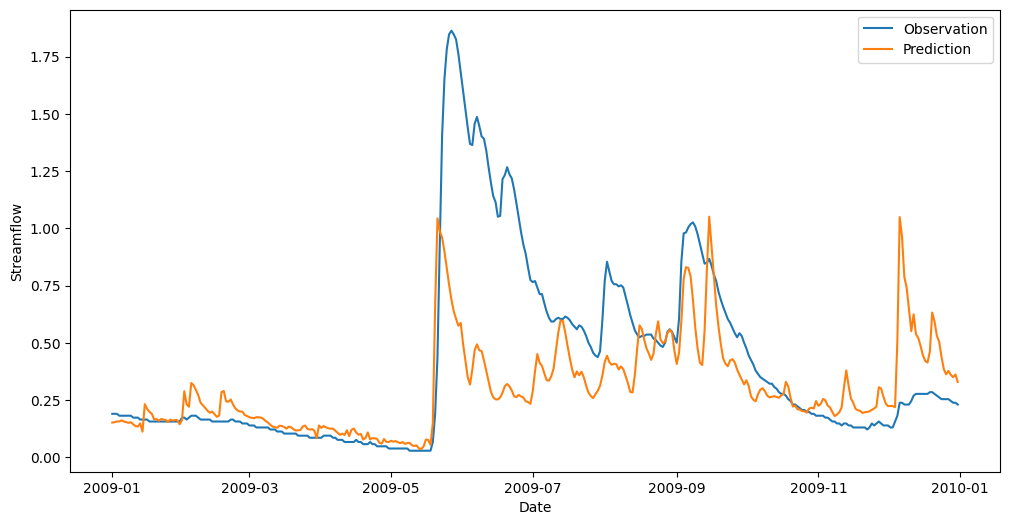

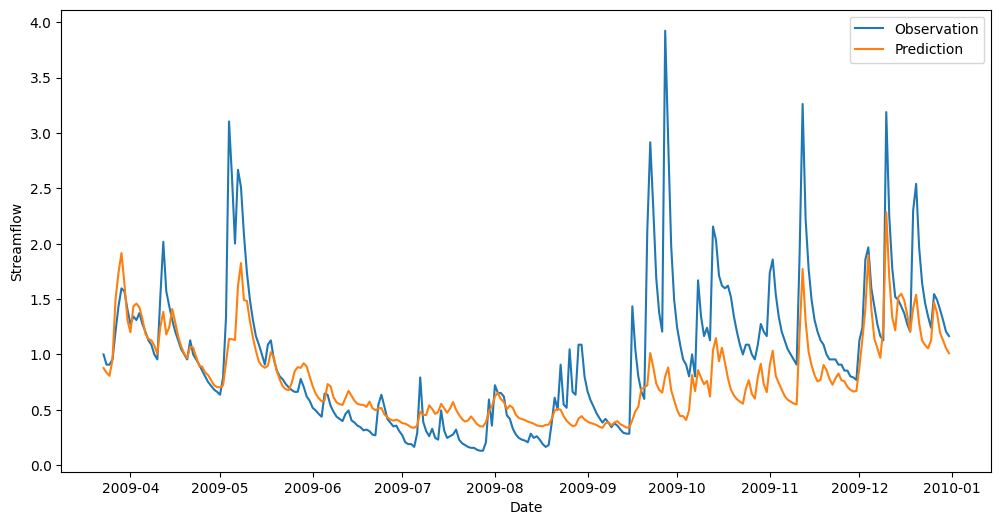

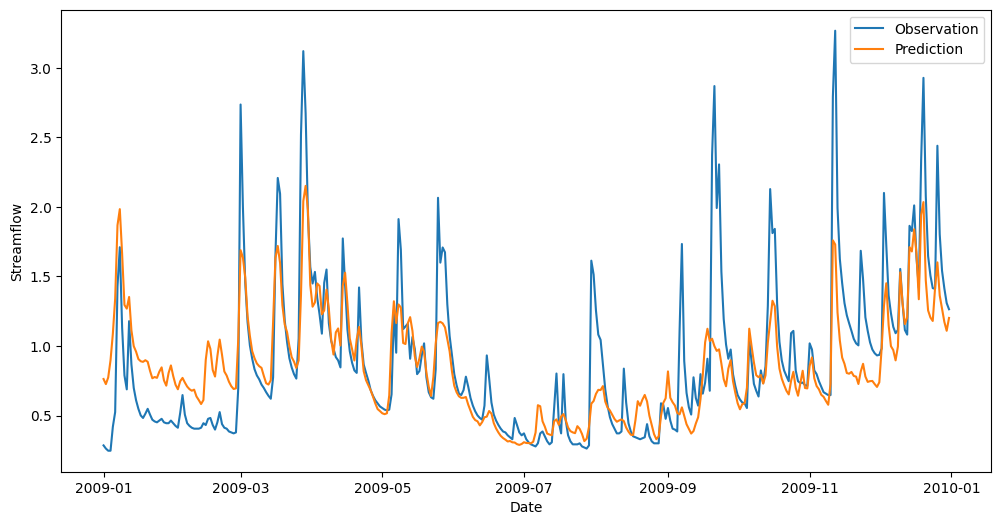

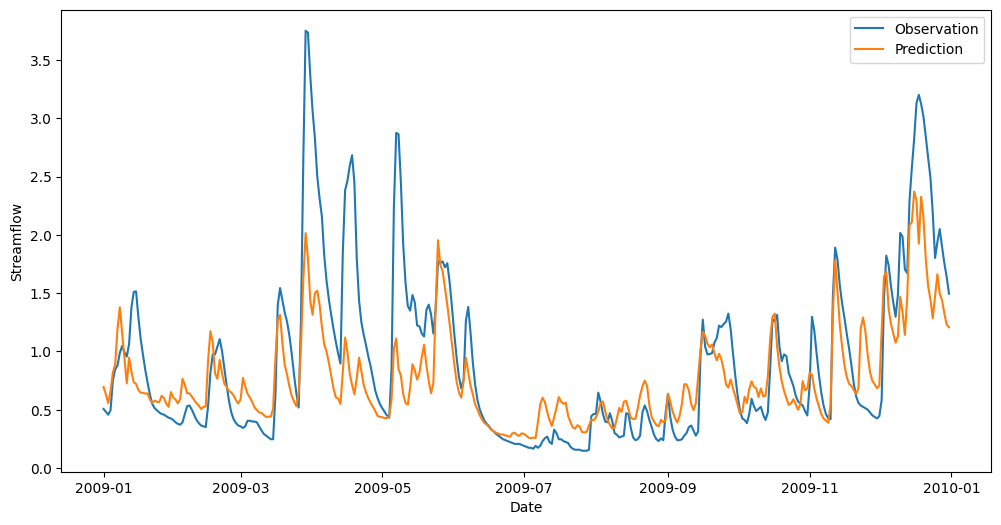

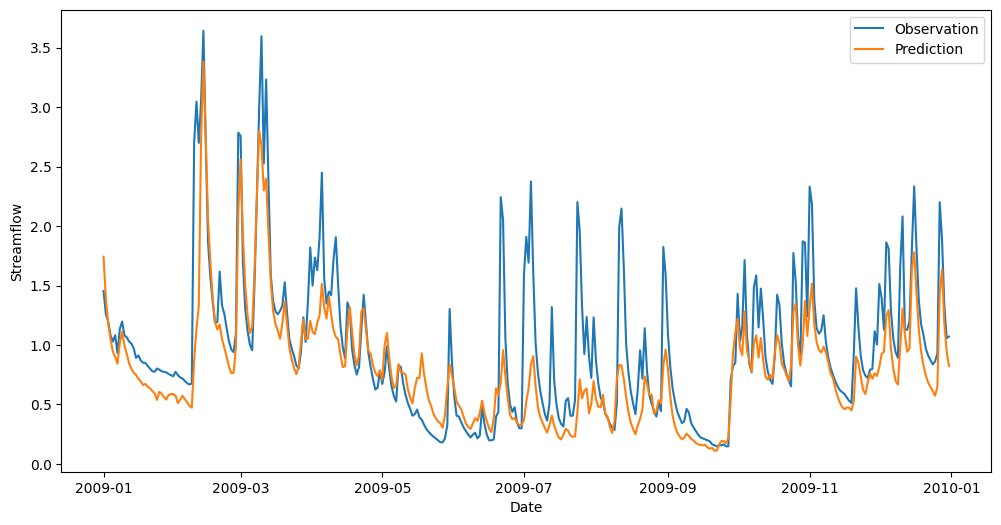

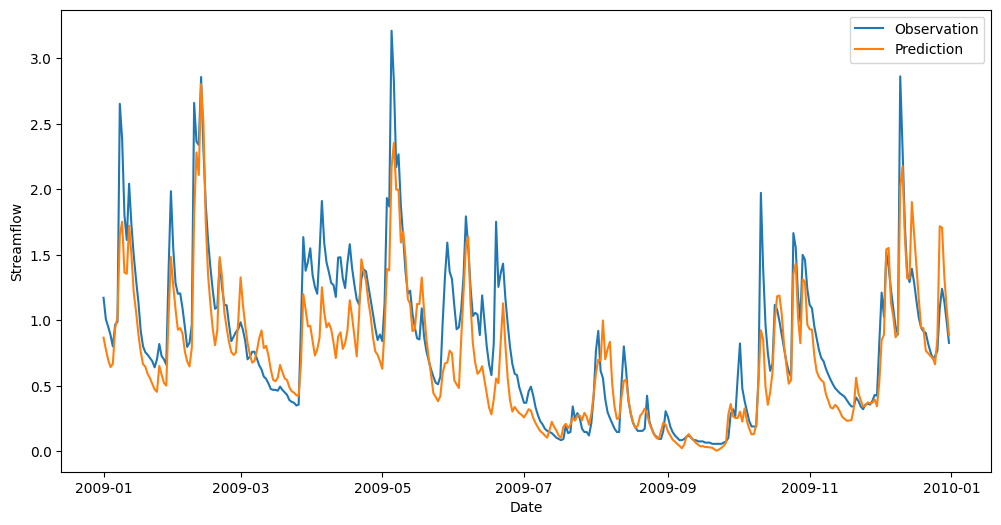

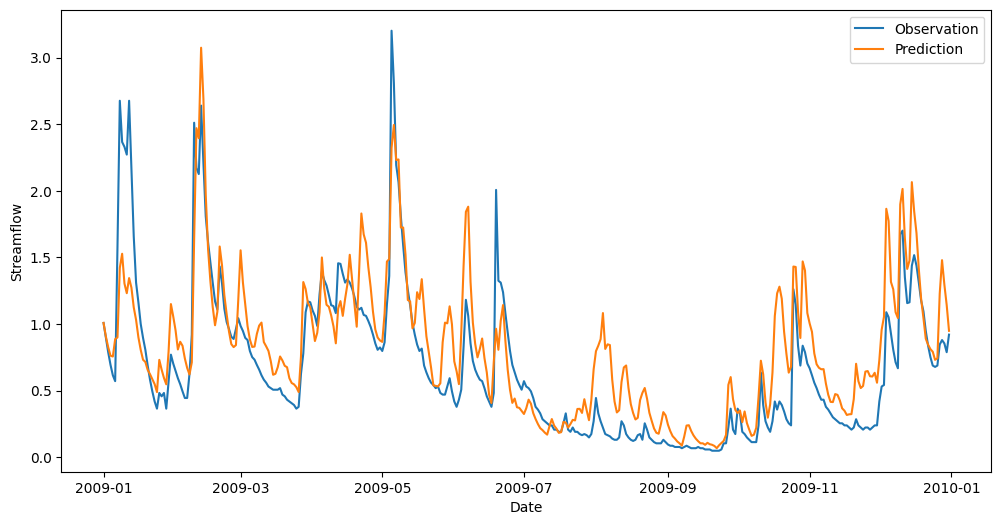

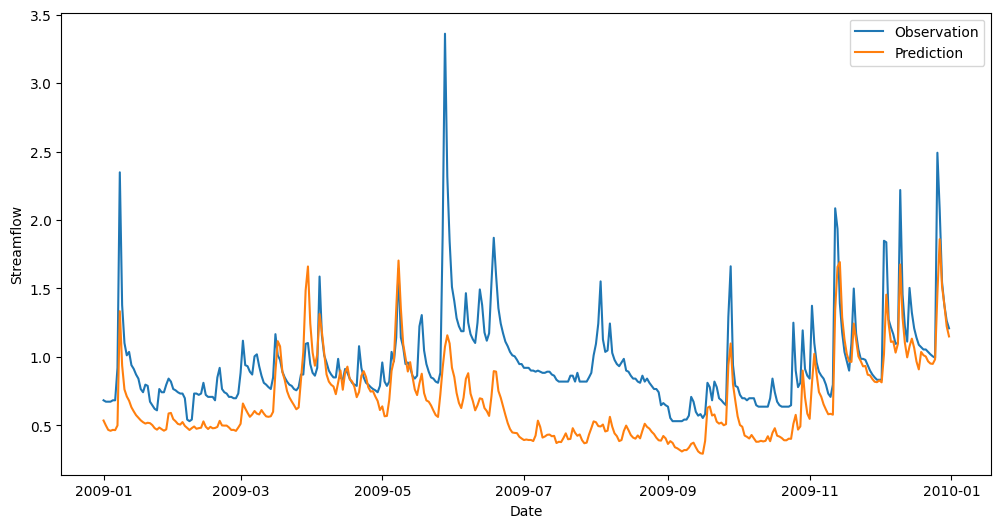

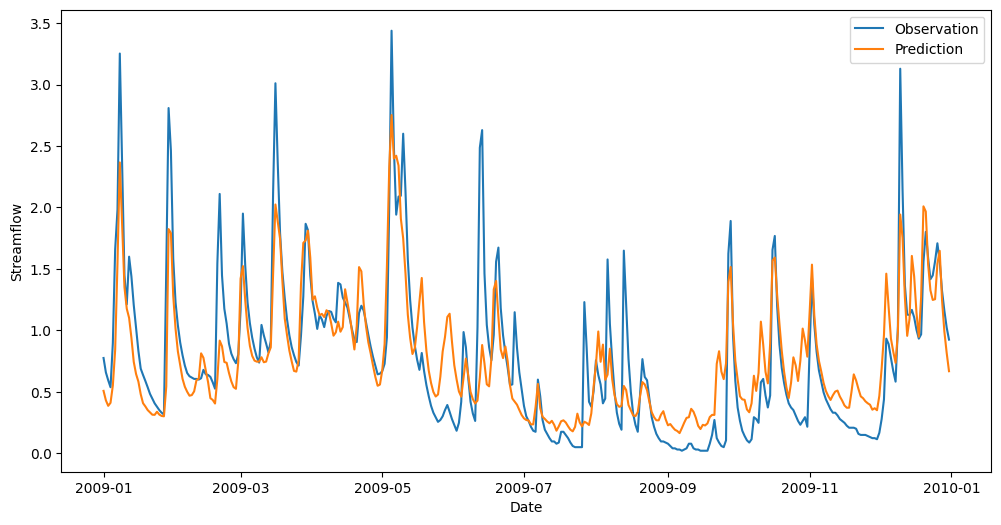

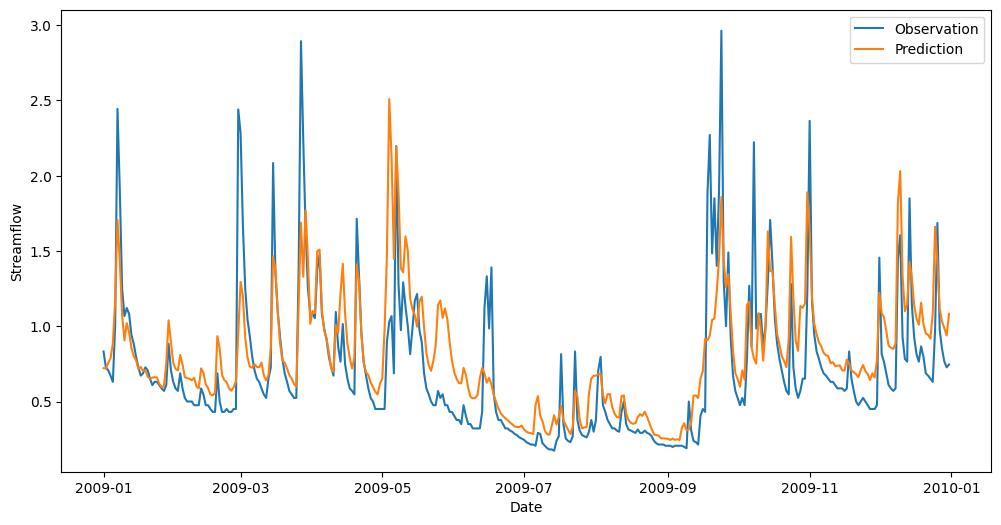

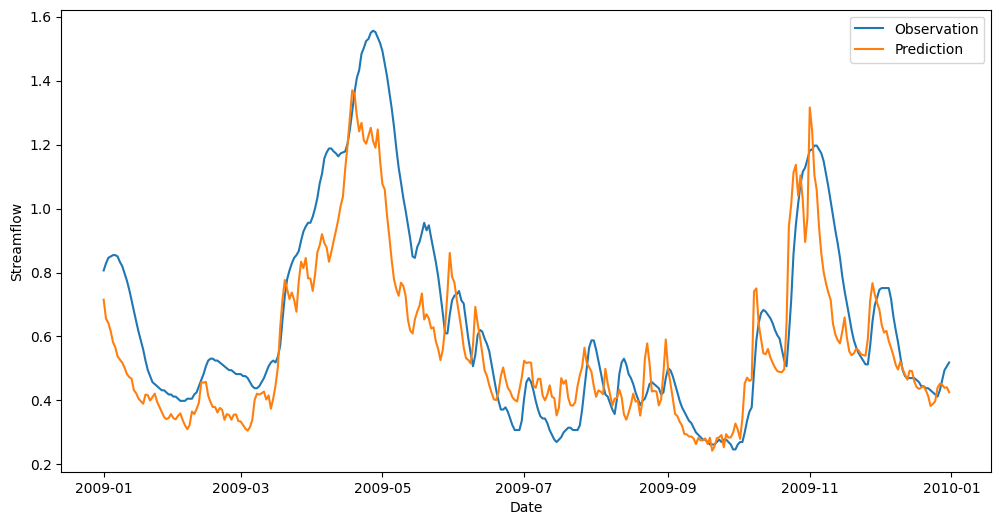

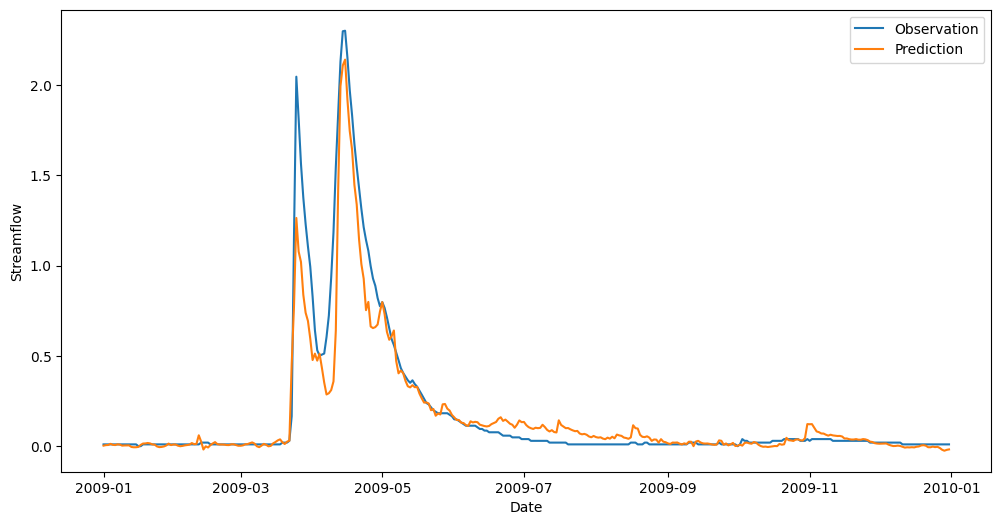

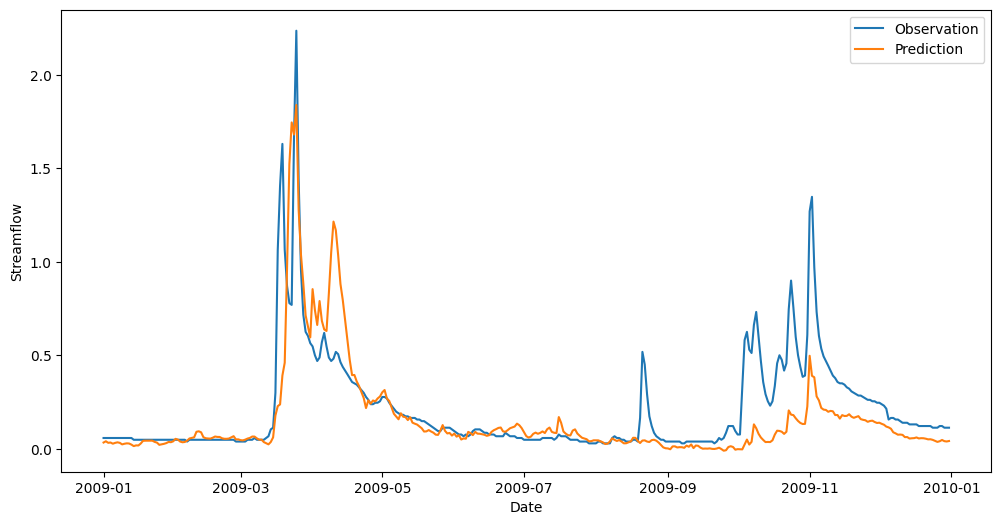

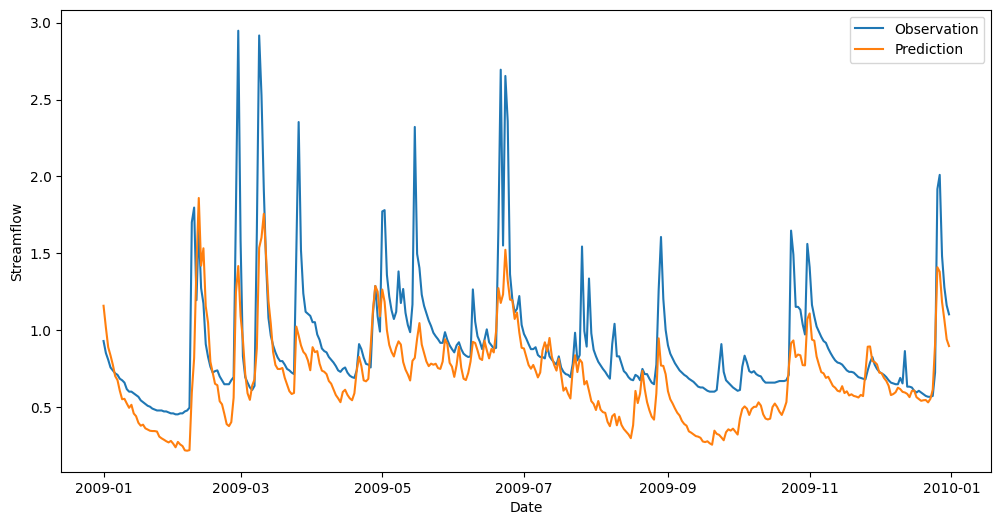

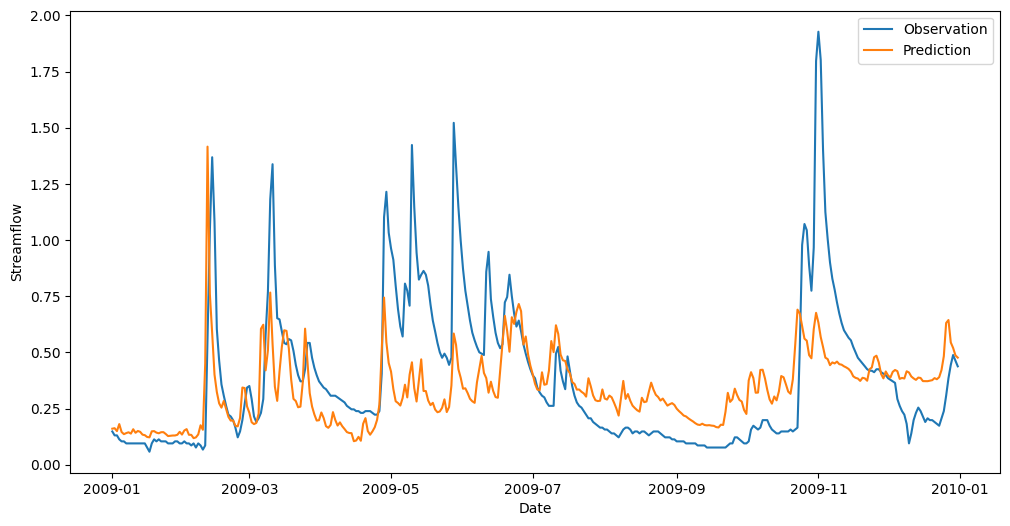

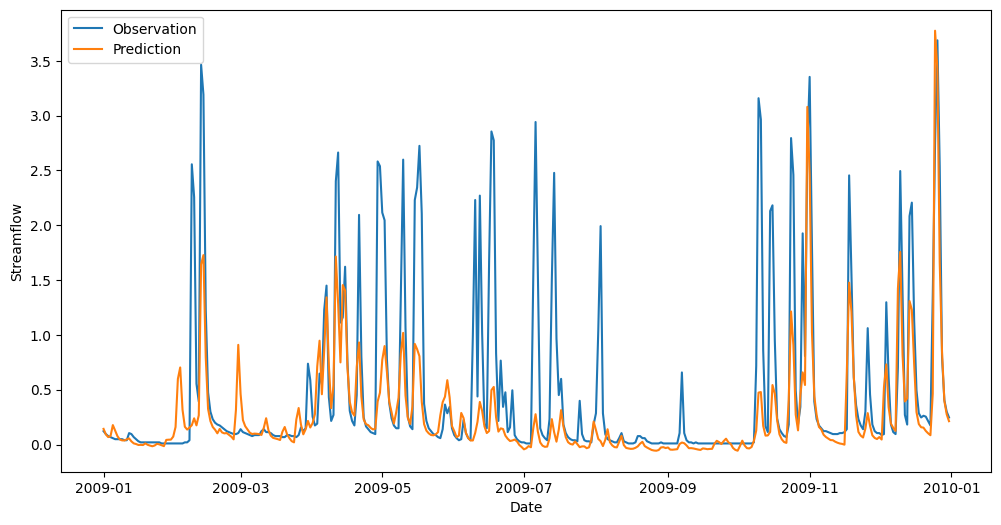

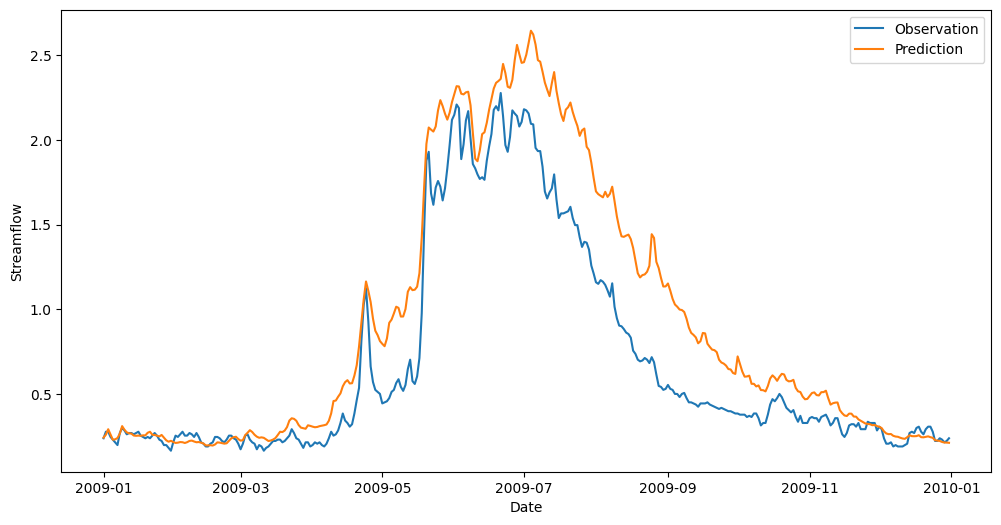

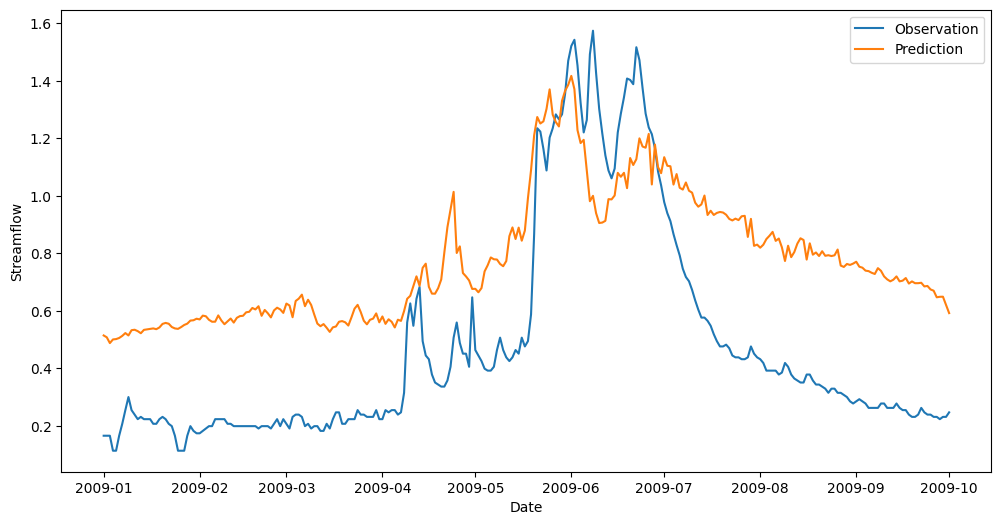

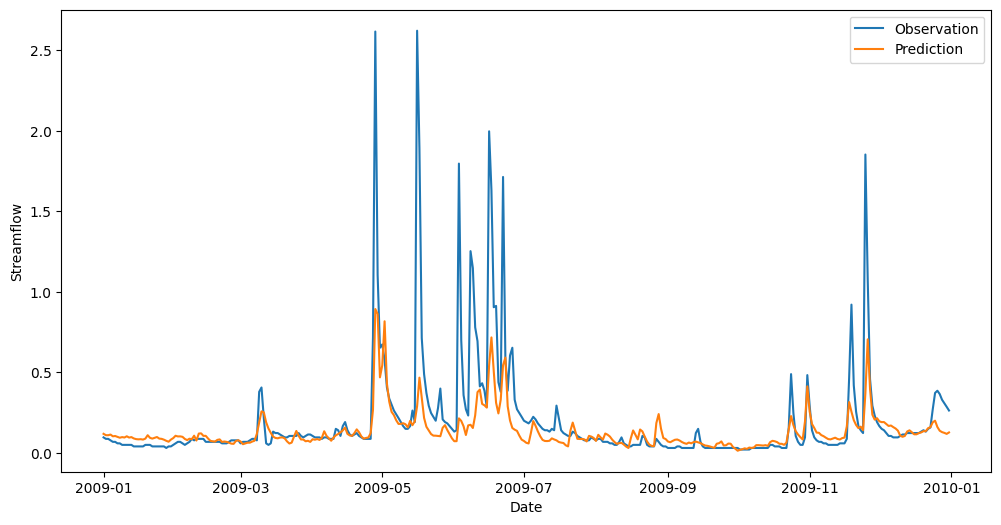

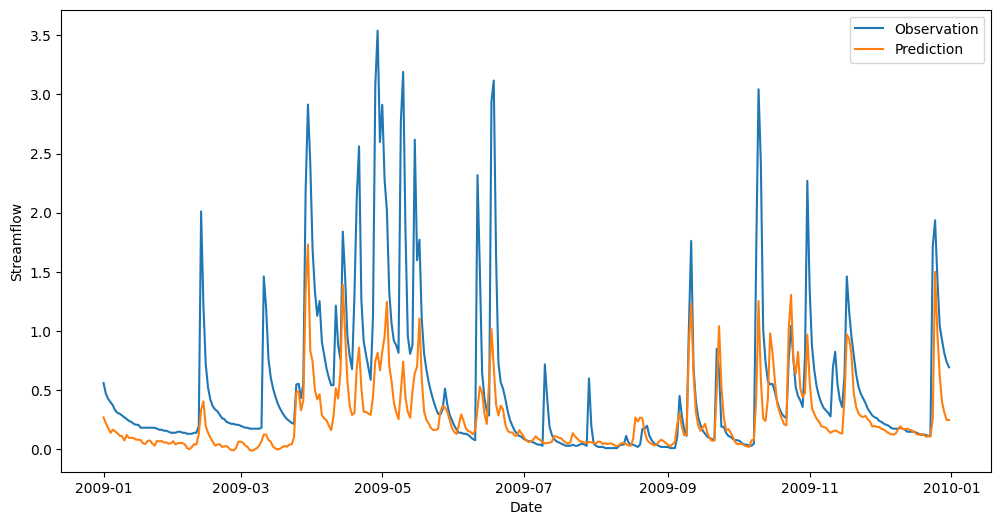

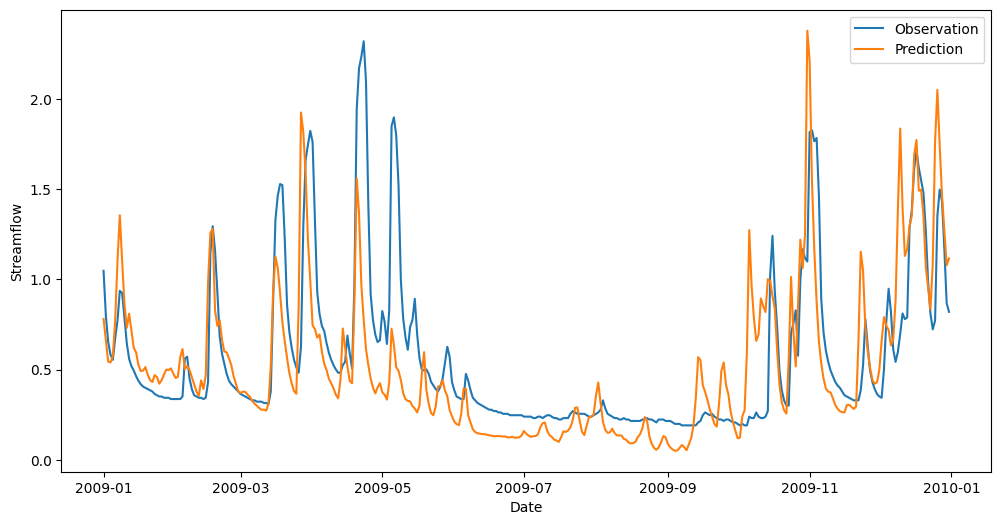

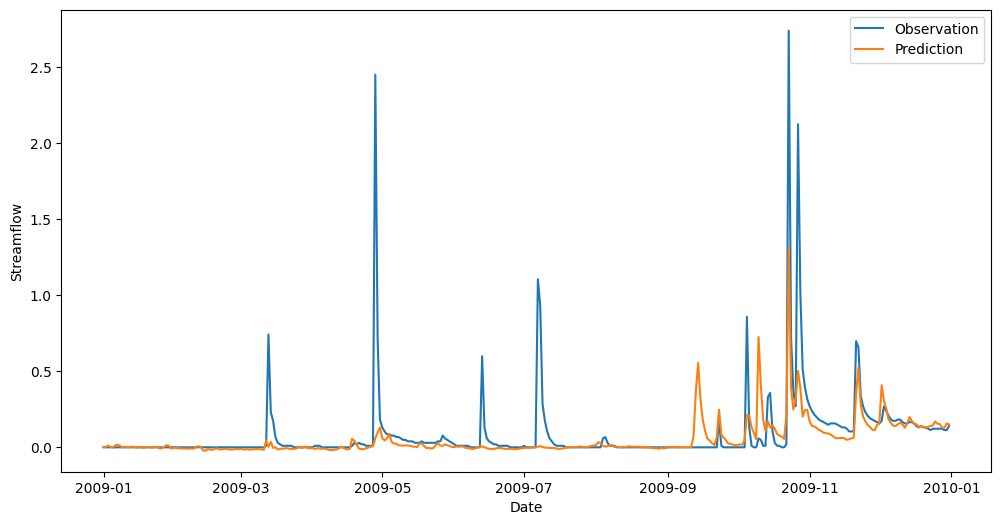

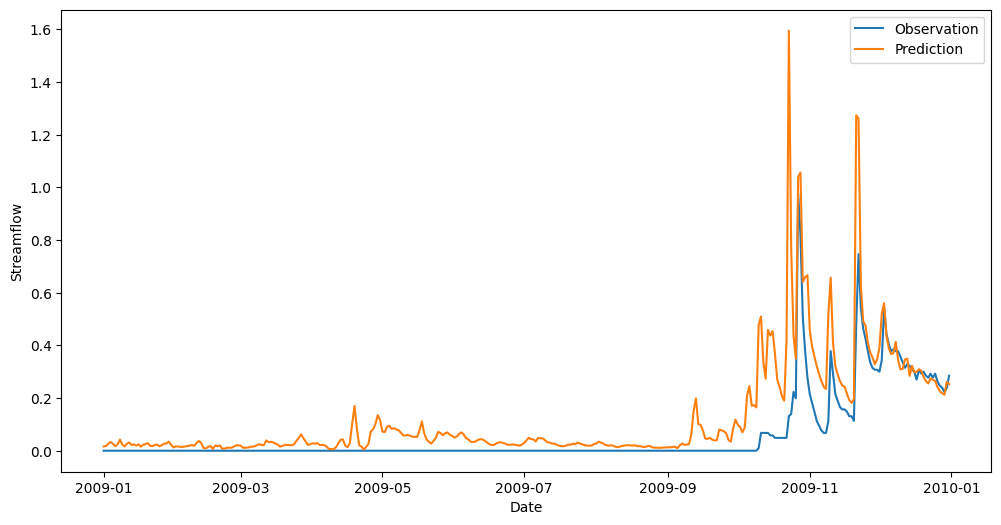

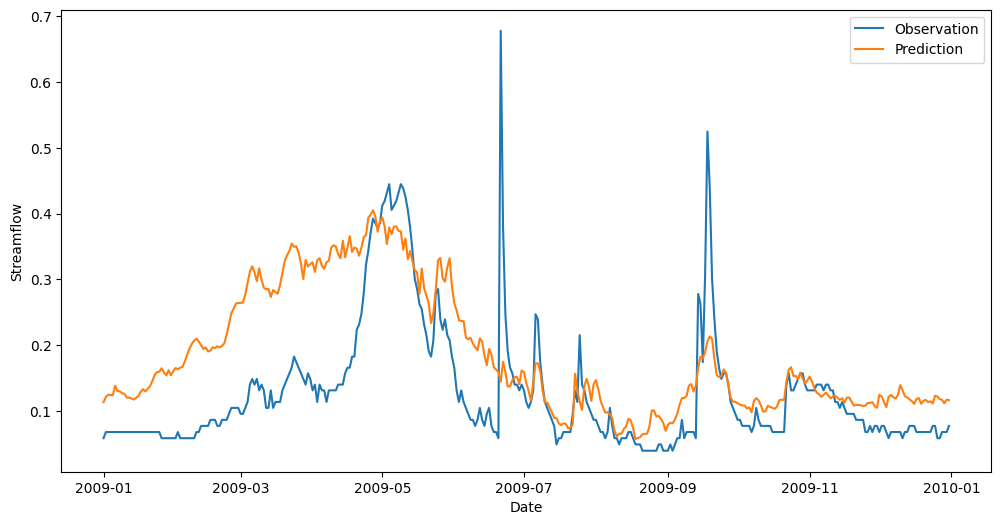

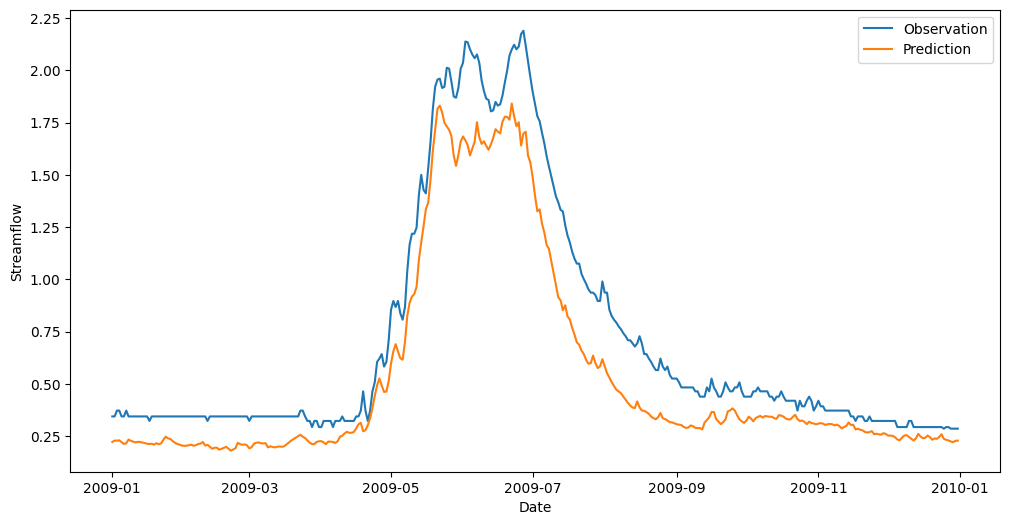

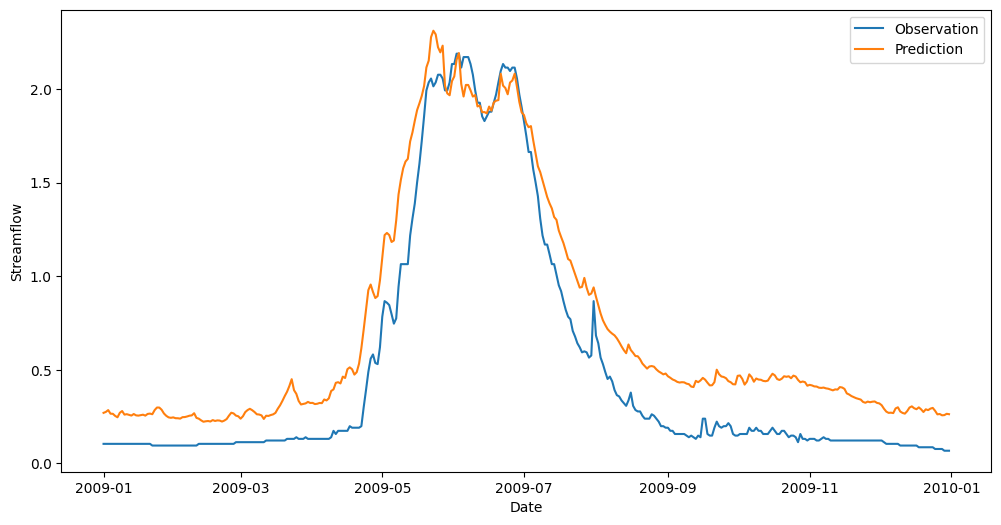

In [2]:
data = pl.read_parquet("/Users/nicolaslazaro/Desktop/work/pub-usa/results/evaluation/eval_2025-11-03_071735/model_name=mamba_275k_fold_1_tweaked_log1p/seed=42/predictions.parquet")
data


ids = ["camels_01139000",
       "camels_01557500",
       "camels_01632000",
       "camels_01632900",
       "camels_02027500",
       "camels_02051000",
       "camels_02059500",
       "camels_02111180",
       "camels_02235200",
       "camels_02384540",
       "camels_02422500",
       "camels_02479560",
       "camels_03021350",
       "camels_03070500",
       "camels_03076600",
       "camels_03165000",
       "camels_03281100",
       "camels_03592718",
       "camels_04045500",
       "camels_05057200",
       "camels_05291000",
       "camels_05444000",
       "camels_05458000",
       "camels_05593575",
       "camels_06280300",
       "camels_06291500",
       "camels_06814000",
       "camels_06917000",
       "camels_08014500",
       "camels_08101000",
       "camels_08158700",
       "camels_08380500",
       "camels_09035900",
       "camels_09066300"
]

for gid in ids:
    subset = data.filter(
        (pl.col("group_identifier") == gid) &
        (pl.col("model_name") == "mamba_275k_fold_1_tweaked_log1p") &
        (pl.col("prediction_date").dt.year() > 2008) &
        (pl.col("prediction_date").dt.year() < 2010)
    )

    plt.figure(figsize=(12, 6))
    plt.plot(subset["prediction_date"].to_numpy(), subset["observation"].to_numpy(), label="Observation")
    plt.plot(subset["prediction_date"].to_numpy(), subset["prediction"].to_numpy(), label="Prediction")
    plt.xlabel("Date")
    plt.ylabel("Streamflow")
    plt.legend()
    plt.show()

## Load predictions and compute NSE

In [3]:
# Load predictions from parquet file
calc = MetricCalculator.from_parquet(
    "/Users/nicolaslazaro/Desktop/work/pub-usa/results/evaluation/eval_2025-11-03_071735/model_name=mamba_275k_fold_1_tweaked_log1p/seed=42/predictions.parquet"
)

# Compute LogNSE per basin (simulation mode, so all lead_time=1)
metrics = calc.compute_metrics(
    metrics=["nse"],
    exclude_filled=True,  # Only real observations
    group_by=["model_name", "group_identifier"]
)

print(f"NSE computed for {metrics.height} basins")
metrics.head()

NSE computed for 52 basins


model_name,group_identifier,NSE
str,str,f64
"""mamba_275k_fold_1_tweaked_log1…","""camels_01139000""",0.752651
"""mamba_275k_fold_1_tweaked_log1…","""camels_01557500""",0.762576
"""mamba_275k_fold_1_tweaked_log1…","""camels_01632000""",0.631005
"""mamba_275k_fold_1_tweaked_log1…","""camels_01632900""",0.744501
"""mamba_275k_fold_1_tweaked_log1…","""camels_02027500""",0.661811


## Summary statistics

In [4]:
# Remove NaN values (if any)
clean_metrics = metrics.filter(~pl.col("NSE").is_nan())

print(f"Valid NSE values: {clean_metrics.height}")
print(f"\nNSE Statistics:")
print(clean_metrics.select("NSE").describe())

Valid NSE values: 52

NSE Statistics:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ NSE       │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 52.0      │
│ null_count ┆ 0.0       │
│ mean       ┆ -0.305237 │
│ std        ┆ 2.992832  │
│ min        ┆ -15.73411 │
│ 25%        ┆ 0.363292  │
│ 50%        ┆ 0.616477  │
│ 75%        ┆ 0.728304  │
│ max        ┆ 0.92738   │
└────────────┴───────────┘


## CDF Plot

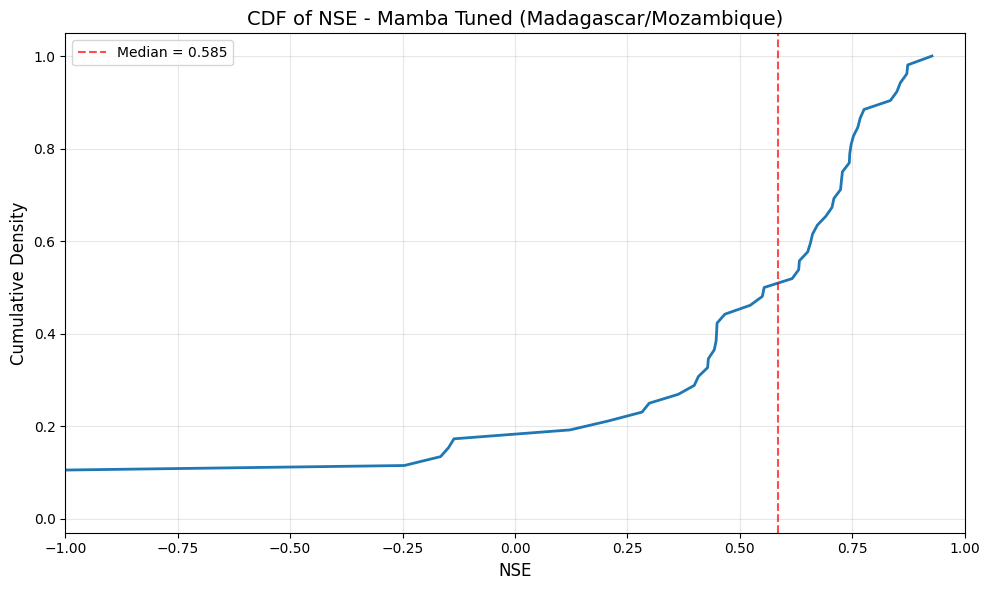


Median NSE: 0.585
Mean NSE: -0.305


In [5]:
# Get NSE values
nse_values = clean_metrics["NSE"].to_numpy()

# Sort for CDF
nse_sorted = sorted(nse_values)
n = len(nse_sorted)
cdf = [i / n for i in range(1, n + 1)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(nse_sorted, cdf, linewidth=2)
plt.xlabel("NSE", fontsize=12)
plt.ylabel("Cumulative Density", fontsize=12)
plt.title("CDF of NSE - Mamba Tuned (Madagascar/Mozambique)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim([-1, 1])

# Add median line
median_nse = clean_metrics["NSE"].median()
plt.axvline(median_nse, color='red', linestyle='--', alpha=0.7, label=f'Median = {median_nse:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nMedian NSE: {median_nse:.3f}")
print(f"Mean NSE: {clean_metrics['NSE'].mean():.3f}")